# Tutorial and Demo

## Simulator Block Scheme

- Absorption filters and reflection filter are now time varying $\longrightarrow$ cannot be swapped
- We need two delay line blocks to implement the whole model
    - Higher computational complexity
    - Double Interpolation operation
    - Higher physical accuracy

<img src='block_scheme.png'>

## Filters Implementation

In [1]:
# Explain the goal of the simulator and the usecase it is designed for

# Show the architecture of the simulator

# Explain the filtering steps


In [2]:
# Tutorial on how to set up the simulation

# Definition of the environment

# Definition of the length of the filters and of the interpolation (accuracy vs performance)

# Definition of source signals and background noise to be added to the simulation

# Generation of microphone received signals

(76175,)


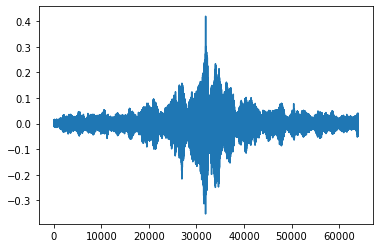

In [3]:
# Define simulation environment with moving source and random signal
import pyroadacoustics as pyroad
import numpy as np
import scipy.signal

from scipy.io import wavfile
samplerate, data = wavfile.read('siren.wav')
data = scipy.signal.resample(data, int(len(data) * 8000 / samplerate))

data = np.reshape(data[:,0], (-1, 1))
data = data / max(data)
data = np.reshape(data, -1)
print(np.shape(data))

fs = 8000
t = np.arange(0,5,1/fs)
f = 3000
env = pyroad.Environment(fs = fs)
# src_signal = np.sin(2 * np.pi * f * t)
src_signal = data
# src_signal = np.random.randn(len(t))
env.add_source(np.array([3,5,1]), trajectory_points=np.array([[3,20,1], [3,-20,1]]), source_velocity=np.array([5]), signal=src_signal)
env.add_microphone_array(np.array([[0,0,1]]))
env.add_background_noise(SNR=0)
env.set_simulation_params("Allpass", True, True)
signal = env.simulate()

# Run simulation and plot signals received at microphone array
import matplotlib.pyplot as plt
plt.plot(signal[0])

# Plot spectrogram of received signal to show doppler

# Show comb filtering effect using FFT representations

# Listen to signal produced by simulator

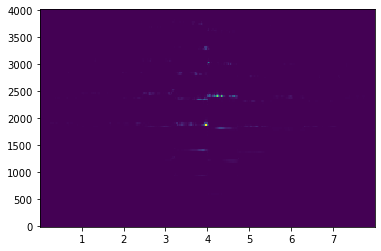

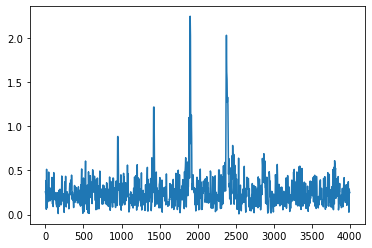

In [4]:
import scipy.signal
from scipy.io.wavfile import write
ff, tt, Sxx = scipy.signal.spectrogram(signal[0], fs = fs)
plt.figure()
plt.pcolormesh(tt, ff, Sxx, shading='auto')
write('output.wav', fs, signal[0])


Nfft = 2048
f_axis = np.linspace(0, fs / 2, int(Nfft / 2 + 1))
fft_signal = np.fft.fft(signal[0], Nfft)
plt.figure()
plt.plot(f_axis, abs(fft_signal[:int(Nfft/2 + 1)]))



array([ 0.61092341,  0.07825791, -2.14214925, ...,  0.9876428 ,
       -0.55330999, -0.85659231])

In [18]:
a = np.asarray(np.reshape(data, -1))


array([ 7.60454207e-05, -7.59772384e-05,  7.59094983e-05, ...,
       -7.62526493e-05,  7.61831232e-05, -7.61140480e-05])